### Sampling Methods for Imbalanced Samples
#### Project for the Statistical Modelling Course - Felix Adam

### 1. Introduction

There are many classification tasks, which try to deal with finding rare cases, such as diseases, oil spills or fraudulent customers. What makes these tasks difficult is the low prevalence of "interesting" cases in the data. A simple example demonstrates the issues with dealing with such data:

Doctors in a hospital lately failed to detect a rare disease in patients, so the hospital asks it's local statistician to help the doctors with this task. Let's assume that 1 person out of 100 has this rare, but deadly diseases. The statistician uses data from the hospital, which includes information on 5000 patients, to build a classifier. When tested on some new data, the classifier had very high accuracy, but somehow still failed to correctly predict the disease in patients. The issue in this case is, that the classifier had learned to predict "healthy" cases, since only 1 percent of the training data was actually sick. In general, with such highly imbalanced datasets, classifieres tend to perform badly, sine they learn the features of the majority class (Kuhn and Johnson, 2013).

A potential remedy for this class imbalance-issue is the use of different sampling methods, to train the classifier on a "balanced" sample. These methods include the removal of cases from the majority class, the repeated sampling of cases from the minority class or the introduction of synthetic instances in order to get a balanced sample. 

The following notebook contains a discussion of the class imbalance issue and potential remedies using sampling methods. I will first present under- and oversampling, as well as Synthetic Minority Oversampling (SMOTE) (Chawla & Bowyer, 2002) using a simple, tractable example with logistic regression. I'll then compare the performance of different sampling methods using simulated data.

My findings show, that sampling techniques such as under-sampling and SMOTE can help with improving the detection of the minority class in unbalanced samples. However, there is always a trade-off between precision and recall when applying sampling techniques. 

#### Librarie, settings and code.

In [1]:
%matplotlib inline

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import datasets
import itertools
from sklearn.utils import shuffle
from IPython.display import HTML
from sklearn.datasets import make_classification

# Simulating , if False, simulated data will be loaded
simulate = False
save = False

# Filepath to simulation data
filepath = "simulation_data/"

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a> .
By default, I am loading previously simulated data. When `simulate` is set to `True`, then simulations are re-run. 
This can take up to 1.5 hours. When `simulate` is `False`, pre-simulated data will be loaded from the corresponding folder in `filepath`.''')

In [5]:
"""
Helper functions

The following functions are being used throughout the notebook. 
Specific functions or ideas such as `correct_intercept_logit` and `smote_undersampler`are discussed when needed."""

# Function for making gaussian classification problem
def make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_min, mean_majority, sd_majority, cov_maj, random_state = "None"):
    
    """Helper function for creating classification problem with gaussians"""
    
    # Set random state
    if random_state != 'None':
        np.random.seed(random_state)
    
    # Split into majority and minority sizes
    n_minority = int(base_rate * n)
    n_majority = int((1-base_rate)* n)
        
    # Get mean of majority from seperation parameter
    #mean_majority = seperation * mean_minority
    
    # Assign covariance matrices
    cov_minority = np.array([[sd_minority[0],cov_min], [cov_min,sd_minority[1]]])
    cov_majority = np.array([[sd_majority[0],cov_maj], [cov_maj,sd_majority[1]]])
    
    # Make 2d multivariate for minortiy and majority class, assign classes
    x_minority = np.random.multivariate_normal(mean_minority,cov_minority, check_valid ='warn', size = n_minority)
    y_minority = np.ones(n_minority)
    
    x_majority = np.random.multivariate_normal(mean_majority,cov_majority, check_valid ='warn', size = n_majority)
    y_majority = np.zeros(n_majority)
    
    # Concatenate both to arrays
    x = np.concatenate((x_minority,x_majority),axis = 0)
    y = np.concatenate((y_minority,y_majority), axis = 0)
    
    # Shuffle
    x,y = shuffle(x,y)
        
    # Return arrays
    return x, y

# Helper function for plotting 
def plot_2d(X,y, title = '', figsize = (8,6)):
    
    fig, ax = plt.subplots(1,1, figsize = figsize)
    ax.scatter(X[:,0], X[:,1], c= y, alpha = 0.8, edgecolor='k')
    
    # Prettify
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set(xlabel="$X_1$", ylabel="$X_2$")
    
 # Helper function for scoring and displaying model performance   
def score_model(y_true,y_predicted):
    
    " Helper function for scoring and displaying"
    # Get accuracy metrics
    accuracy = metrics.accuracy_score(y_true,y_predicted, normalize=True,sample_weight=None)
    precision = metrics.precision_score(y_true,y_predicted)
    recall = metrics.recall_score(y_true,y_predicted)
    
    # Make a nice output
    accuracy_df = pd.DataFrame([[accuracy, precision, recall]], columns=['Accuracy', 'Precision', 'Recall'])
    
    return accuracy_df
    
# Helper function for plotting the confusion matrix
def plot_confusion(cnf_matrix, classes = [0,1], title = 'Confusion Matrix', cmap = plt.cm.Blues,
                  figsize =  (8,6)):
    
    " Helper function for plotting a confusion matrix"
    fig, ax = plt.subplots(1,1, figsize = figsize)
    
    # Make heatmap plot
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Title, colorbar and tickmarks
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Write number of predictions in matrix
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if cnf_matrix[i, j] > thresh else "black")
    
    # Add labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Helper function for plotting the decision boundary in R^2
def plot_decision_boundary(model, X_test, y_test, area = [-5,5], figsize = (8,6), ):
    
    """Helper function for plotting the decsision boundary in R^2 """
    
    # Make meshgrid
    xx, yy = np.mgrid[area[0]:area[1]: 0.1, area[0]:area[1]: 0.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict probabilities on the grid
    probs = model.predict_proba(grid)[:,1 ].reshape(xx.shape)
    
    # Make figure and plot
    fig, ax = plt.subplots(figsize=figsize)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    
    # Set colorbar and labels for colorbar
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    
    # Scatter data points, color by class
    ax.scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)
    
    # Set ax labels
    ax.set(aspect="equal",
           xlim=(area[0],area[1]), ylim=(area[0], area[1]),
           xlabel="$X_1$", ylabel="$X_2$")
    
    
# Helper function for correcting the intercept in models fitted on re-sampled data
def correct_intercept_logit(fitted_model, population_y, sample_y):
    
    """ Helper funcion for correcting the intercept of a logit model after re-sampling.
        Both population inputs should be 0-1 class labels, where 1 is the class of interest""" 
    
    # Get the current intercept
    current_intercept = fitted_model.intercept_
    
    # Get population values, estimate them as averages from the population sample
    tau = sum(population_y) / len(population_y)
    
    # Resampled population values
    y_bar = sum(sample_y) / len(sample_y)
    
    # Calculate corrected coefficient 
    corrected_intercept = current_intercept - np.log( ((1-tau) / tau) * (y_bar / (1-y_bar)))
    
    # Set model intercept to corrected intercept
    fitted_model.intercept_ = corrected_intercept

# Helper function for plotting ROC curve and AUC
def plot_roc_curve(model,X_test,y_test, figsize = (8,6)):
    
    """Helper function for plotting the ROC curve and AUC of given classifier"""
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[::,1]
    
    # Get false positive and true positive rates
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    # Get AUC
    auc = metrics.auc(fpr, tpr)
    
    # Make figure
    fig, ax = plt.subplots(figsize = figsize)
    
    # Diagonal
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    
    # Plot ROC curve
    plt.plot(fpr,tpr,label="ROC Curve; AUC ="+str(round(auc,2)))
    
    # Legend and labels
    plt.legend(loc = 4)
    
    # Set ax labels
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
    
# Helper function for comparing original sample and re-sampled data set
def plot_resample(X,y, X_resample, y_resample, title = '', figsize = (16,8)):
    
    fig, axes = plt.subplots(1,2, figsize = figsize)
    fig.suptitle(title, fontsize=16)
    axes[0].scatter(X[:,0], X[:,1], c= y, alpha = 0.8, edgecolor='k')
    axes[1].scatter(X_resample[:,0], X_resample[:,1], c= y_resample, alpha = 0.8, edgecolor='k')

    axes[0].set_title('Original Set')
    axes[1].set_title('Re-Sampled')

    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.spines['left'].set_position(('outward', 10))
        ax.spines['bottom'].set_position(('outward', 10))
        ax.set(xlabel="$X_1$", ylabel="$X_2$")
        
#Helper function for comparing decsision boundaries of two classifiers in R^2
def plot_decision_resample(models, X_test,y_test, titles , suptitle = 'Decision Boundaries', area = [-5,5], figsize =(16,8)):
    
    """Helper function for comparing decsision boundaries in R^2 """
    fig, axes = plt.subplots(1,len(models), figsize = figsize)
    
    fig.suptitle(suptitle)
    
    # Make meshgrid
    xx, yy = np.mgrid[area[0]:area[1]: 0.1, area[0]:area[1]: 0.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    for i in range(0,len(models)):
        
        # Predict probabilities on the grid
        probs = models[i].predict_proba(grid)[:,1].reshape(xx.shape)
        
        # add contour
        contour = axes[i].contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
        
         # Scatter data points, color by class
        axes[i].scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
                       cmap="RdBu", vmin=-.2, vmax=1.2,
                       edgecolor="white", linewidth=1)
        
        # Set title 
        axes[i].set_title(titles[i])
        # Set ax labels
        axes[i].set(aspect="equal",
               xlim=(area[0],area[1]), ylim=(area[0], area[1]),
               xlabel="$X_1$", ylabel="$X_2$")
        
#Helper function for comparing decsision boundaries of two classifiers in R^2
def plot_decision_resample(models, X_test,y_test, titles , suptitle = 'Decision Boundaries', area = [-5,5], figsize =(16,8)):
    
    """Helper function for comparing decsision boundaries in R^2 """
    # Initiate figures
    fig, axes = plt.subplots(1,len(models), figsize = figsize)
    
    # Set title
    fig.suptitle(suptitle)
    
    # Make meshgrid
    xx, yy = np.mgrid[area[0]:area[1]: 0.1, area[0]:area[1]: 0.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    for i in range(0,len(models)):
        
        # Predict probabilities on the grid
        probs = models[i].predict_proba(grid)[:,1].reshape(xx.shape)
        
        # add contour
        contour = axes[i].contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
        
         # Scatter data points, color by class
        axes[i].scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
                       cmap="RdBu", vmin=-.2, vmax=1.2,
                       edgecolor="white", linewidth=1)
        
        # Set title 
        axes[i].set_title(titles[i])
        # Set ax labels
        axes[i].set(aspect="equal",
               xlim=(area[0],area[1]), ylim=(area[0], area[1]),
               xlabel="$X_1$", ylabel="$X_2$")
    
    # Add shared colorbar
    cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    ax_c =  fig.colorbar(contour, cax=cax, **kw)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    
    
# Helper function for applying sample method, fitting and scoring for a logistic regression model
def sample_fit_metrics(model, X_train , X_test, y_train, y_test, sampler= None, undersampler_strategy = None):
    
    # No technique, just fit the model
    if sampler == None:
            model.fit(X_train,y_train)
        
    # Special Case when smote and undersampling
    elif sampler == smote_undersampler:
        
        X_train_sampled, y_train_sampled  = smote_undersampler(smote,X_train,y_train,undersampler_strategy)
        
        # Fit model
        model.fit(X_train_sampled, y_train_sampled)
    
        # Correct the intercept
        correct_intercept_logit(model,y_train,y_train_sampled)
    
    # Else apply other sampling techniques
    else:
 
        # Apply sampling strategy
        X_train_sampled, y_train_sampled = sampler.fit_resample(X_train,y_train)
    
        # Fit model
        model.fit(X_train_sampled, y_train_sampled)
    
        # Correct the intercept
        correct_intercept_logit(model,y_train,y_train_sampled)
    
    # Make prediction on testing set
    y_pred = model.predict(X_test)
    
    # Probabilities for AUC 
    y_proba = model.predict_proba(X_test)[::,1]
    
    # Get accuracy metrics
    accuracy = metrics.accuracy_score(y_test,y_pred, normalize=True,sample_weight=None)
    precision = metrics.precision_score(y_test,y_pred)
    recall = metrics.recall_score(y_test,y_pred)
    auc = metrics.roc_auc_score(y_test, y_proba)
    
    return accuracy, precision, recall, auc

# Helper function for plotting the results of the simulations
def plot_results(accuracy_pd,precision_pd,recall_pd,auc_pd, title= " "):

    fig, axes = plt.subplots(2,2,figsize = (12,10), sharey= False, sharex= False)

    # Plot accuracy data
    accurcacy_plot = accuracy_pd.plot(ax = axes[0][0],legend= False)
    precision_plot = precision_pd.plot(ax = axes[0][1], legend = False)
    recall_plot = recall_pd.plot(ax = axes[1][0], legend = False)
    auc_plot = auc_pd.plot(ax = axes[1][1], legend = False);
    
    plt.legend()
    
    accurcacy_plot.set_title('Accurcay')
    precision_plot.set_title('Precision')
    recall_plot.set_title('Recall')
    auc_plot.set_title('AUC')
    
    fig.suptitle(title)
    
# Helper function for making an imbalance 
def custom_random_undersample(strategy, X_train,y_train):
    
    # Make column names
    names = ['X'+str(nr) for nr in range(0,X_train.shape[1])]

    # Store data in data frame
    df = pd.DataFrame.from_records(X_train, columns= names)
    
    # Add class column
    df['Class'] = y_train
    
    # Nr. Negative Class instances
    n_negative = len(df[df.Class == 0])

    # Nr. Postive Class Instances
    n_positive = len(df[df.Class == 1])
    
    # Get number of instances that should be removed (has to be integer)
    remove_n = int(n_negative - (strategy / (1-strategy)) * n_positive)
 
    # Get random indices from the majority class which have to be removed
    drop_indices = np.random.choice(df[df.Class == 0].index, remove_n, replace=False)

    # Get resampled pd
    resampled_pd = df.drop(drop_indices)

    # Transform to arrays and return
    X_resample = np.array(resampled_pd.loc[:, resampled_pd.columns != 'Class'])
    y_resample = np.array(resampled_pd.loc[:, resampled_pd.columns == 'Class']).ravel()

    return X_resample, y_resample

# Custom SMOTE undersample function 
def smote_undersampler(smote,X_train,y_train,strategy):
    
    # Use smote to resample
    X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)
    
    # Use custom undersampler to undersample the resulting model
    X_train_smote_undersampled, y_train_smote_undersampled = custom_random_undersample(strategy
                                                                                       ,X_train_smote, 
                                                                                       y_train_smote)
    
    # Return
    return X_train_smote_undersampled, y_train_smote_undersampled
    

### 2. The Class Imbalance Problem

Simply put, one can speak of class imbalance if the classes in a sample are not evenly represented. With any given classification task, it is important to be aware of the so called base rate or relative frequency of "interesting" cases in the data.  With a low base rate, classifiers tend to have a high accuracy, with low recall. For example, the number of prostate cancer cases in the United States was 112 per 100,000 men in 2018 (National Cancer Institute), which is equivalent to a base rate of 11.2 percent. A naive approach to classifying patients into healthy or sick by simply classifying everyone as healthy would result in an accuracy of almost 90 percent. 

In the following section I'll demonstrate the class imbalance issue using a simulated dataset.

##### Example in $R^2$

I am generating 5000 instances, each with two features. The base rate of the class of interest is 1 percent. Further, I assume that features for both classes are distributed according to a multivariate normal distribution. The covariance between features inside of each class is 0, and the distance between cluster means is low. 

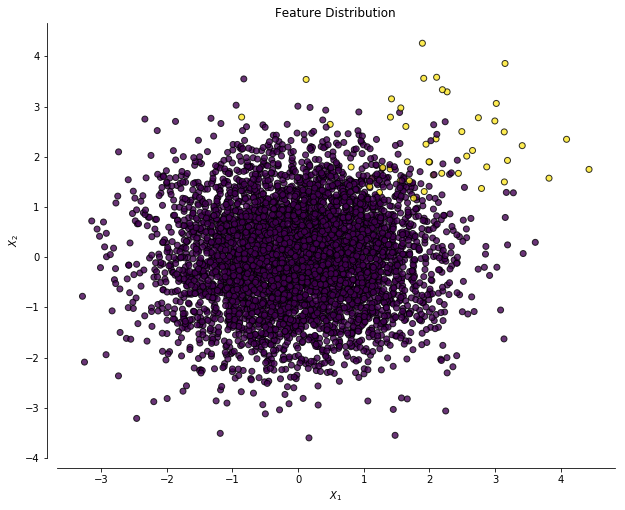

In [6]:
# Random state for reproduceability
seed = 5

# Base rate and sample size
base_rate = 0.01
n = 5000

# Properties of the minority class distribution
mean_minority =  np.array([2,2])
sd_minority = np.array([1,1])
cov_minority = 0

# Majority class parameters
mean_majority = np.array([0,0])
sd_majority = np.array([1,1])
cov_majority = 0

# Make distribution and classes
x, y = make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_minority, mean_majority,
                        sd_majority,cov_majority, random_state = seed)

# Plot
plot_2d(x,y, figsize= (10,8), title= 'Feature Distribution')

The purple points represent the majority class and the yellow points the minority class. Throughout this notebook I will refer to the class of interest as the minority class.

My goal is to build a classifier that predicts the instances of the minority class well. Looking at the distribution, it is easy to see that this is not a simple classification task, independtly of the class imbalance. However it helps to present the issue. I will come back later to the discussion of when class imbalance is an issue in general.

Having simulated the data, I will follow the standard procedure of splitting it into training- and testing-sets, fitting the model on the training set and evaluating the performance on the testing set. Throughout this notebook I'm using `sklearn` and the `LogisticRegression` classifier. By default, this classifier uses either LASSO or ridge regression to identify features. While feature selection can help with class-imbalance issues, I will set the penalty term in the model very low, so that the model uses all features. 

,Accuracy,Precision,Recall
0,0.9932,0.75,0.48


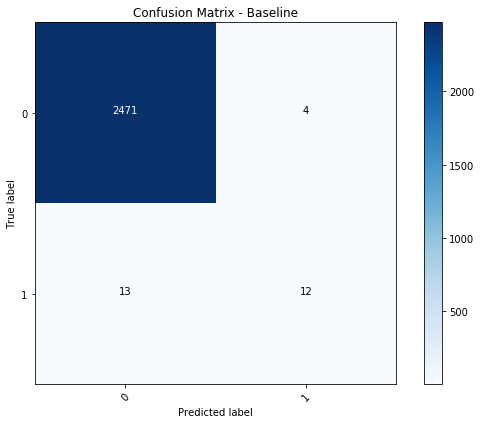

In [7]:
## Train test, split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.5, stratify = y, random_state= 0)

# Instantiate the model, intercept,no class weights (default), C parameter is 1/lambda, 'l1' penalty essentially removed, 
baseline_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
baseline_model.fit(X_train,y_train);

# Make predictions 
baseline_pred = baseline_model.predict(X_test)

# Get confusion matrix using sklearn metrics
cnf_matrix = metrics.confusion_matrix(y_test,baseline_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Baseline', classes= ['0','1'],figsize=(8,6))

# Get confusion matrix and show scores 
score_model(y_test,baseline_pred)

The above confusion matrix and performance metrics are all calculated on the testing set.

As expected, the resulting classifier has very high, almost perfect, accuracy. However, given that the base-rate was 1 percent, accuracy is not a meaningful metric. The precision matrix shows, that the classifier has correctly classified all but 4 instances of the majority class. However, it has only correctly classified 12 out of 25 instances of the minority class, resulting in a recall of 48 percent. Depending on the task at hand, this could be devastating. If the minority class represents a deadly disease, then the classifier failed to recognize the disease in half of the cases.

In general, assesing the performance and which metric to choose depends on the task at hand. But for the sake of the argument I will follow the disease example in which the classifier should have higher recall.

I will now plot the decision boundary of the logistic regression model to show what the clasifier "learned".

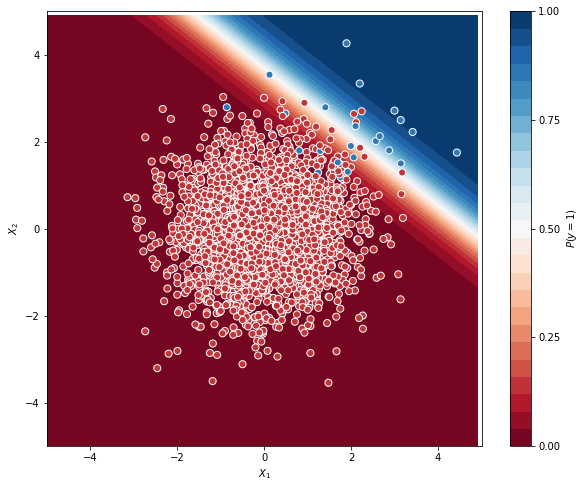

In [8]:
plot_decision_boundary(baseline_model, X_test, y_test,figsize=(10,8))

Recalling, that the feature means of the minority class where at $\mu_{X1} = 2,\mu_{X1} = 2$ and the means of the majority class where $\mu_{X1} = 0,\mu_{X1} = 0$, we can see that the imbalance has shifted decision boundary in favour of the majority class. The outliers of the majority class "conceal" the instances of the minority class in this case. 

Here, a simple solution already appears: Move the decision boundary. In this case a move to a decsision boundary of approx. 0.25 would already capture all minority class instances, as indicated by the ROC curve below. This is of course at the expense of a slightly higher false positive rate.

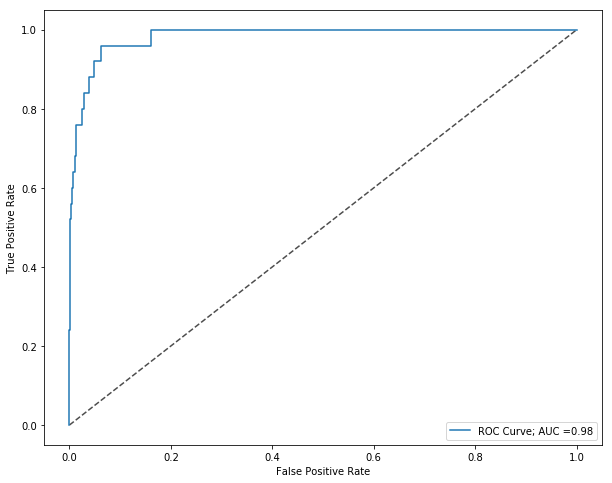

In [9]:
plot_roc_curve(baseline_model, X_test, y_test,figsize= (10,8))


##### Counter Example

I will shortly present a counter example, which still has a high class imbalance, but in which a logistic regression model would still work well.

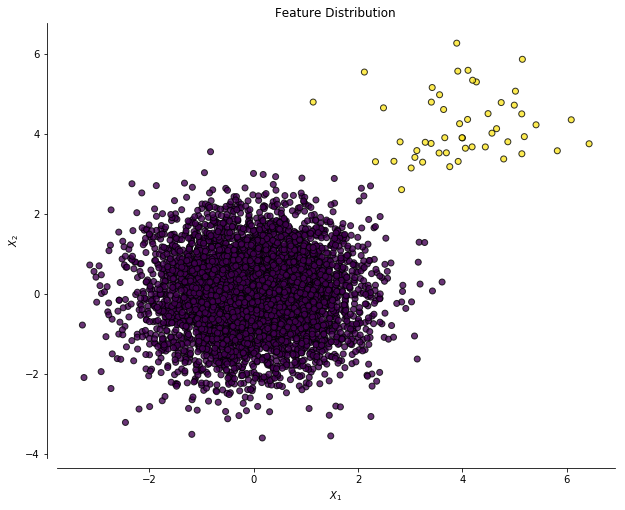

In [10]:
# Base rate and sample size
base_rate = 0.01
n = 5000

# Properties of the minority class distribution
mean_minority =  np.array([4,4])
sd_minority = np.array([1,1])
cov_minority = 0

# Majority class parameters
mean_majority = np.array([0,0])
sd_majority = np.array([1,1])
cov_majority = 0

# Make distribution and classes
x_2, y_2 = make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_minority, mean_majority,
                        sd_majority,cov_majority, random_state = seed)


# Plot
plot_2d(x_2,y_2, figsize= (10,8), title= 'Feature Distribution')

The example above has the same base-rate as the previous one. However, due to the larger separation between classes, a classifier would have less of an issue with correctly classifying both cases. 

Having demonstrated the underlying issue, I will now present the previously mentioned sampling techniques for dealing with class imbalances. Throughout the discussion in will continue to work with the previous data set.

### 3. Sampling Techniques

The general idea behind the use of sampling techniques is to construct a new sample from an imbalanced sample in which the relative frequency of both classes is more balanced. In this way, classifiers should be able to better capture the decision boundary between the majority and minority class (Hoens and Chawla, 2013).

When using sampling techniques, one has to make sure not to mix up training and testing sets. The sampling technique should be used only on the training set. The performance of the fitted model should then be assessed on a testing set which hasn't been re-sampled. 

##### Correcting for re-sampling

Further, one has to correct the resulting model for the differences in relative frequencies of the distribution. Given a classification problem where $Y$ represents the classes and $X$ the features, the goal is to find $P(Y \mid X)$. Let's assume that $X$ and $Y$ are from an imbalanced sample, so learning $P(Y \mid X)$ is difficult. Through the use of sampling techniques, one can achieve a balanced sample, where $x$ and $y$ are random variables with joint density $P(x,y)$.  After re-sampling,  $P(x \mid y) = P(X \mid Y)$ but the densities $P ( x ) , P ( y ), P(y \mid x)$ are not equal to $P ( X ) , P ( Y ) ,$ and $P ( Y \mid X )$. However, $P(Y \mid X)$ can now be estimated from $P(x,y)$ using a correction term. To show this, assume that $D$ and $d$ are random samples of size $n$ from the joint distributions $P(X,Y)$ and respectively $P(x,y)$. As $n \rightarrow \infty$

$$P ( Y \mid X , D ) = P ( X \mid Y , D ) \frac { P ( Y \mid D ) } { P ( X \mid D ) } \stackrel { d } { \rightarrow } P ( X \mid Y ) \frac { P ( Y ) } { P ( X ) } = P ( Y \mid X )$$

since $P(X \mid D)$ and $P(Y \mid D)$ both converge in distribution to $P(X)$ and $P(Y)$.

However, the same doesn't hold when we estimate $P(y \mid x,d)$, since as $n \rightarrow \infty$ 

$$P ( y \mid x , d ) = P ( x \mid y , d ) \frac{P ( y \mid d )} {P ( x \mid d )}$$

does not converge in distribution to $P(Y \mid X)$ as the marginals differ.  
However, a way to correct for this is by multiplying $P(y \mid x,d)$ with a correction factor $A_y B$ where A = $ P ( Y \mid D ) /  P ( y \mid d )$ and $B = P ( x \mid d ) P ( X \mid D )$. 

$$ P(y \mid x,d) A_y  B = P ( x \mid y , d ) \frac { P ( y \mid d ) } { P ( x \mid d ) } \frac{P (Y \mid D)} {P(y \mid d)} \frac{P(x \mid d)} {P(X\mid D)} = P(x \mid y, d) \frac {P(Y \mid D)}{P(X\mid D)} $$

$$\stackrel { d } { \rightarrow } P(Y \mid X)$$ 

since $P ( x \mid y , d ) \stackrel { d } { \rightarrow } P ( x \mid y ) = P ( X \mid Y )$ (King and Zeng, 2001). 

In practice, $P(Y \mid D) = \tau$ can be estimated as the sample mean from the original sample, and $P(y \mid d) = \bar{y}$ is known since it results from the re-sampling strategy. So $A_y = \tau / \bar{y} $. Further,  $B$ can be calculated from the the marginals:

$$ B = \frac {P(x \mid d)} {P(X \mid D)} = \left[ \sum _ {y} P ( y | x , d ) A _ { y } \right] ^ { - 1 }$$


In the case of a binary outcome, $B^{-1}$ is 

$$ B^{-1} = P( y = 1 \mid x , d )\frac{\tau} {\bar{ y }} + [ 1 - P ( y = 1 \mid x , d ) ] \frac{( 1 - \tau ) }{  1 - \bar { y } }$$ 

(For a full discussion of the sample correction see King and Zeng, 2001) 

##### Prior correction for logistic regression

For logistic regression, the required correction can be calculated from the transformation of the logg odds. Logistic regression learns 

$$\log \frac { P ( Y = 1 \mid X ) } { P ( Y = 0 \mid X ) } = \phi ( x ) ^ { T } \beta + \beta_0$$

which can be transformed using Bayes rule

$$ \log \frac { P ( X \mid Y= 1 ) P(Y = 1) } { P (X  \mid Y = 0) P(Y = 0)} = \phi ( x ) ^ { T } \beta + \beta_0$$

however, using re-sampling methods, logistic regression learns the following log odds,

$$ \log \frac { P ( x \mid x= 1 ) \bar{y} } { P (x  \mid y = 0)(1-\bar{y})} = \phi ( x ) ^ { T } \hat{\beta} + \hat{\beta_0}$$

where $\bar{y} $ represents the re-sampled frequency of the minority class. In order to correct for this, the intercept or bias of the logistic regression model has to be adjusted by

$$ \log \frac { P ( x \mid y= 1 ) P(Y = 1) } { P (x  \mid y = 0) P(Y = 0)} = \phi ( x ) ^ { T } \hat{\beta} + \hat { \beta } _ { 0 } - \ln \left[ \left( \frac { 1 - \tau } { \tau } \right) \left( \frac { \overline { y } } { 1 - \overline { y } } \right) \right]$$

where as discussed before, $P(Y =1) = \tau$ is the relative frequency of ones in the population and $P(y= 1) = \bar{y}$ is the sample frequency after re-sampling. Consequently, for logistic regression, only the intercept (also known as bias) has to be adjusted (King and Zeng, 2001). 

Subsequently, I'm using the `correct_intercept_logit` function which is defined in the "Helper functions" section above to apply this correction after fitting the model on the re-sampled training-data. The function calculates $\tau$ and $\bar{y}$ as the sample averages of the original training sample and the re-sampled data set respectively: 

```python
corrected_intercept = current_intercept - np.log( ((1-tau) / tau) * (y_bar / (1-y_bar)))
```

#### 3.1 Under-sampling

One way to achieve a balanced sample is to remove instances from the majority class until a desired sample distribution has been reached. This does not necessarily mean that the sample should be equally balanced. The simplest technique for under-sampling is random under-sampling. In random under-sampling, instances from the majority class are choosen at random and removed (Hoens and Chawla, 2013). While this method is fairly easy to implement, one has to be aware that potentially valuable information could be discareded when removing instances (Hoens and Chawla, 2013). This is why various extensions to random under-sampling have been developed, such as removing instances based on clustering methods. These methods try to identify _redundant_ or _noisy_ instances in the data.

For the following discussion I will present the random under-sampling method using Pythons `imblearn` library. As befo
re, I'll fit a logistic regression model on the re-sampled training set. Then, after applying the correction discussed above to the intercept, I'll assess the model performance on the evaluation set. 

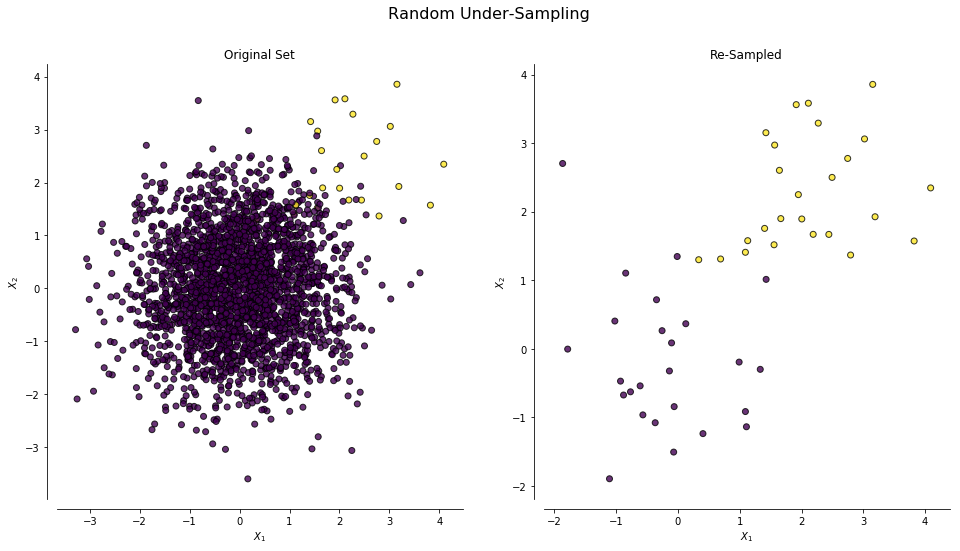

In [11]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the sampler, sampling_strategy = 1 means that a completly balanced sample should be generated
rus = RandomUnderSampler(sampling_strategy=1, random_state=2)

X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)
plot_resample(X_train,y_train,X_train_undersampled,y_train_undersampled,title = 'Random Under-Sampling')

The above output is shows the effect of undersampling on the training data. The `RandomUnderSampler` generates a balanced sample by randomly removing instances from the purple majority class.

,Accuracy,Precision,Recall
0,0.986,0.380952,0.64


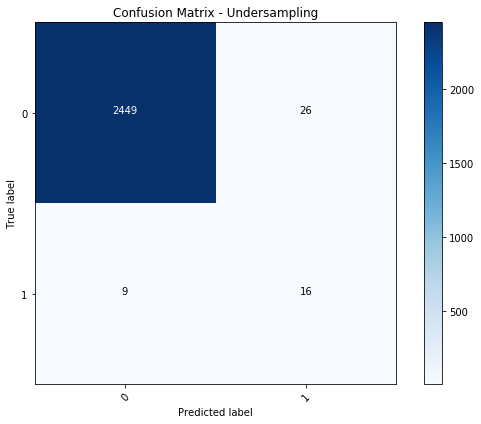

In [12]:
# Instantiate the model, intercept,no class weights (default), 'l1' penalty essentially removed
undersampled_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
undersampled_model.fit(X_train_undersampled,y_train_undersampled);

# Correction the intercept
correct_intercept_logit(undersampled_model, y_train, y_train_undersampled)

# Now make predictions
undersample_pred = undersampled_model.predict(X_test)

# Get confusion matrix using sklearn metrics
cnf_matrix = metrics.confusion_matrix(y_test,undersample_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Undersampling', classes= ['0','1'],figsize=(8,6))

# Get confusion matrix and show scores 
score_model(y_test,undersample_pred)

The use of random under-sampling has had a positive impact on recall, as shown above. On the other hand, the tradeoff between improving recall and a loss of precision can be seen. There are more false positive predictions than in the baseline case, but these are relatively low compared to the true negatives.

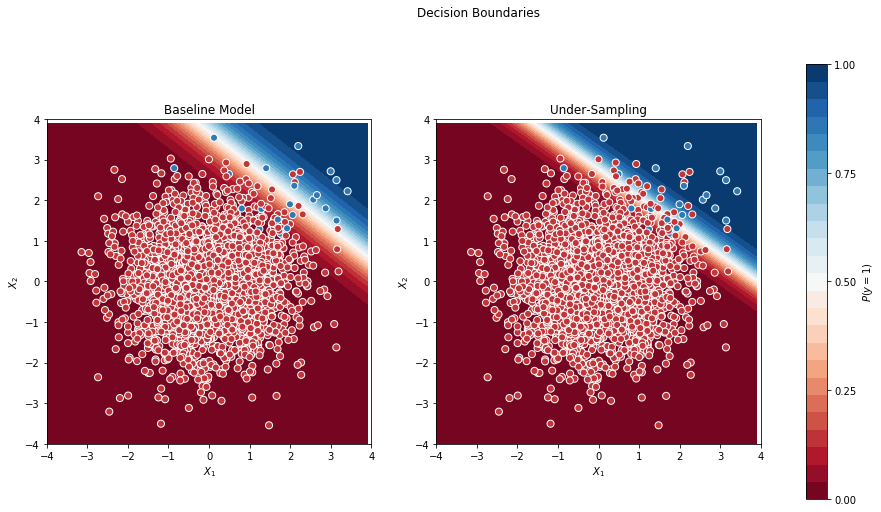

In [13]:
# Compare resulting decsision boundaries
plot_decision_resample([baseline_model,undersampled_model],X_test,y_test, titles= ['Baseline Model', 'Under-Sampling'],
                       area= [-4,4])

While it is hard to see at first, the decision boundary has become narrower or "sharper". In the balanced sample, 
Further, the boundary moved towards the left, which is also represented by the higher recall and then lower precision. 

#### 3.2 Random Over-Sampling

Another method to get a balanced sample is over-sampling. Instead of removing instances of the majority class like in under-sampling, in over-sampling instances of the minority class are repeated, until a desired balance has been reached. In this case, issues could arise from overfitting, since more weight is put on the oversampled instances. For this reason "smarter" techniques for over-sampling have been developed, such as SMOTE, which I will discuss later.

Following the same estimation strategy as before, I will now created a balanced sample using the `RandomOverSampler` from `imblearn`. 

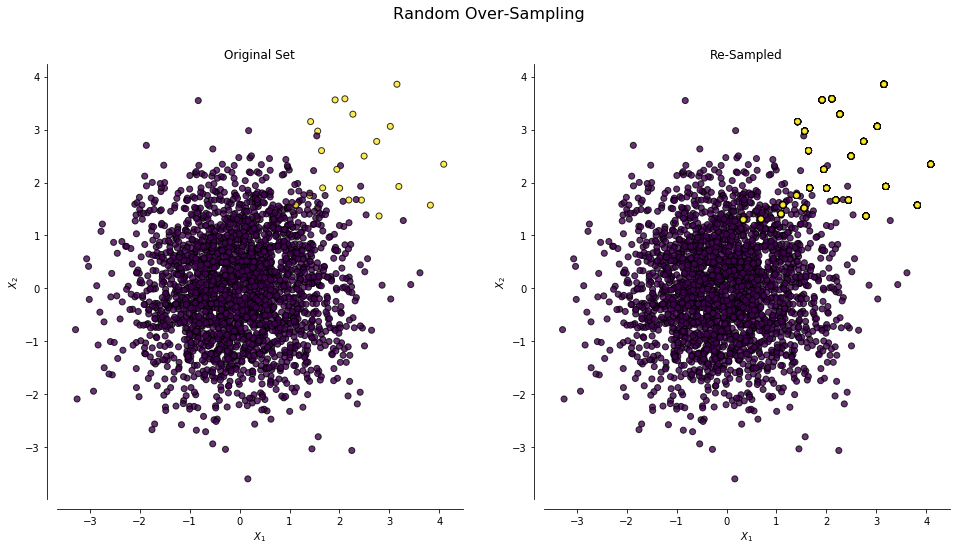

In [14]:
from imblearn.over_sampling import RandomOverSampler
random_oversampler = RandomOverSampler(sampling_strategy = 1,random_state=0)
X_train_oversampled, y_train_oversampled = random_oversampler.fit_resample(X_train, y_train)

plot_resample(X_train,y_train,X_train_oversampled,y_train_oversampled,title = 'Random Over-Sampling')

The difference between the original sample and the oversampled version is hard to recognize. However one can slightly see that the yellow points are somewhat "thicker" in the re-sampled dataset. This due to the fact that each instance of the minority class has now been repeated 99 times. Before re-sampling, the dataset contained 25 instances of the minority class and 2475 instances of the minority class. Now the dataset has 2475 instances of each class, due to the repeated sampling of the minority class.

,Accuracy,Precision,Recall
0,0.9928,0.684211,0.52


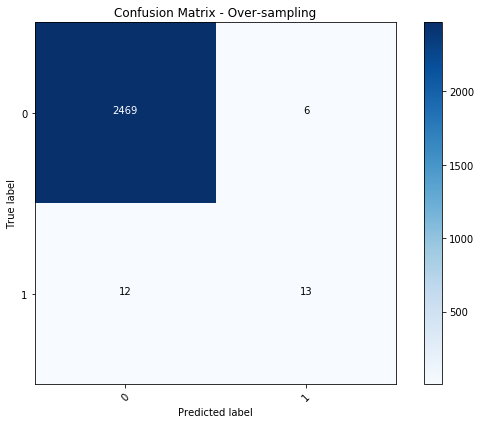

In [15]:
# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
oversampled_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model 
oversampled_model.fit(X_train_oversampled, y_train_oversampled );

# Correct the intercept 
correct_intercept_logit(oversampled_model, y_train, y_train_oversampled)

# Make predictions on testing values
oversample_pred = oversampled_model.predict(X_test)

# Get confusion matrix using sklearn metrics
cnf_matrix = metrics.confusion_matrix(y_test,oversample_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Over-sampling', classes= ['0','1'],figsize=(8,6))

# Get confusion matrix and show scores 
score_model(y_test,oversample_pred)

Using random over-sampling, the out-of-sample performance of the logistic regression did not improve too much compared to the baseline. This could be due to overfitting on the training set. However,  the precision didn't drop as much compared to random under-sampling. I will later run simulations, to compare both strategies in a controlled setting.

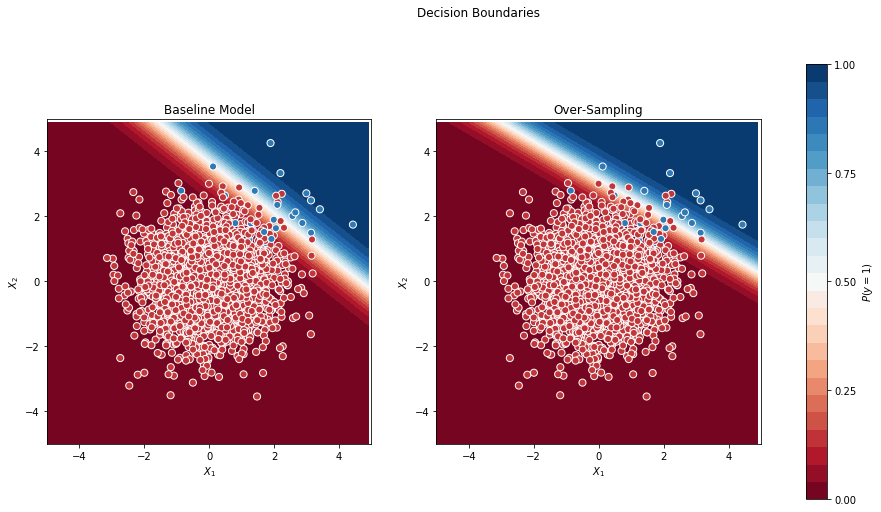

In [16]:
# Compare resulting decsision boundaries
plot_decision_resample([baseline_model,oversampled_model],X_test,y_test, titles= ['Baseline Model', 'Over-Sampling'])

Compraing the decision boundary of the model fitted on the over-sampled data to the baseline model, we can see a shift on the boundary. However, this shift didn't lead to a major improvment in recall. This could be an issue of overfitting to the repeated instances of the minority class. In fact, we can see, that the performance in sample is quite good, with higher recall and no drop in precision, compared to the baseline.

,Accuracy,Precision,Recall
0,0.994,0.777778,0.56


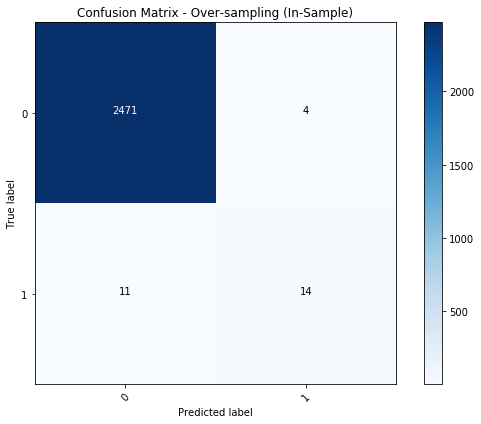

In [17]:
# Make predictions on training values
oversample_pred_insample = oversampled_model.predict(X_train)

# Get confusion matrix using sklearn metrics
cnf_matrix = metrics.confusion_matrix(y_train,oversample_pred_insample)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Over-sampling (In-Sample)', classes= ['0','1'],figsize=(8,6))

# Get confusion matrix and show scores 
score_model(y_train,oversample_pred_insample)

#### 3.3 Synthetic Minority Oversampling Technique (SMOTE)

Given the potential issue of overfitting to the training data, over-sampling methods have been developed which introduce new, synthetic minority class instances to the training data. One of these methods is the Synthetic Minority Oversampling Technique (SMOTE) propsed by Chawla, Bowyer, Hall and Kegelmeyber (2002). SMOTE follows an idea from hand-writing character recognition, developed by Ha and Bunke (1997). They created new training data, by slightly perturbing the images of given characters. Chawla et. al (2002) generalize this method, by generating new minority class instances through perturbations of the features of current instances. 

The SMOTE algorithm takes the k-nearest neighbors of each minority class instance, and introduces a new synthetic instane alongside the line segment between the nearest neighbor and the current instance. Synthetic instances are generated by taking the difference between the feature vector of the instance under consideration and it's nearest neigbor. This difference is then multiplied by a random number between 0 and 1 and added to the feature vector of the current instance. This essentialy creates a random point between two instances of the minority class which is classified as a memeber of the minority class. Chawla et. al (2002) argue, that this forces the decision boundary to become more general compared to random over-sampling. 

An example of the creation of synthetic minority class instances is the following:

A minority class sample with feature vector $X_1=(5,4)$ has the nearest neighbor $X_2(6,5)$. The differnce between the features of both points is $\text{diff}(X_1,X_2) = (1,1)$. A new data-point will then be generated as $X_{synthetic} = X_1 + \text{rand}(0,1) * \text{diff}(X_1,X_2)$. This data-point will now belong to the minority class.

Chawla et. al (2002) propse to use the 5-nearest neigbors to create new instances, but do not argue why. The choice of the number of neighbors has significant effect on the distribution of the features in the minority class as I will show later.

The algorithm is executed in a loop and in every iteration of the loop one instance of the majority class is choosen at random and new synthetic instances are added alongside its k-nearest neighbors. Once introduced to the data, new synthetic features are also considered as k-nearest neighbors of the current data-point in the loop. 

##### Under-sampling and SMOTE Combination

Besides generating synthetic minority class instances, Chawla et al. (2002) also recommend to simultaneously under-sample the majority class. They argue that this essentially reverts the bias of the classifier towards the minority class. The authors argue, that the combination of SMOTE and under-sampling performs better than plain under-sampling.

##### Why SMOTE?

Chawla et al. (2002) argue in favour of SMOTE based on the effect on decision regions. According to the authors, when using random over-sampling, the decision boundaries (especially for random forest classifiers) become particulary narrow and specific to the sample. With SMOTE on the other hand, the decision regions of the minority class grow larger. Therefore, classifiers trained on "smoted" data should generalize better. 

Chawla et al. (2002) test SMOTE on C4.5 ,a tree-based algorithm, RIPPER, a rule based algorithm and a Naive Bayes Classifier. The question is, whether the "generalization" of the decision regions of the tested algorithms also extends to the linear decision boundary of a logistic regression model. I will later try to evaluate the performance of SMOTE when used with logistic regression. 

A possible interpretation of the synthetic data generated by SMOTE is that one has a prior belief about the distribution of the minority class features. The synthetic samples can then be intepreted as a random draw from said distribution. However, SMOTE is in a sense non-parametric, since it doesn't use any information about the feature-space. Further research could be dedicated to building synthetic samples from a distribution learned from the sample itself.

##### Implementation of SMOTE 

I will no demonstrate the implementation of SMOTE using `imblearn` and the `SMOTE` function. I will first demonstrate the effect of SMOTE using different k-neighbors and then evaluate model performance. I'll start with SMOTE without random-under-sampling.

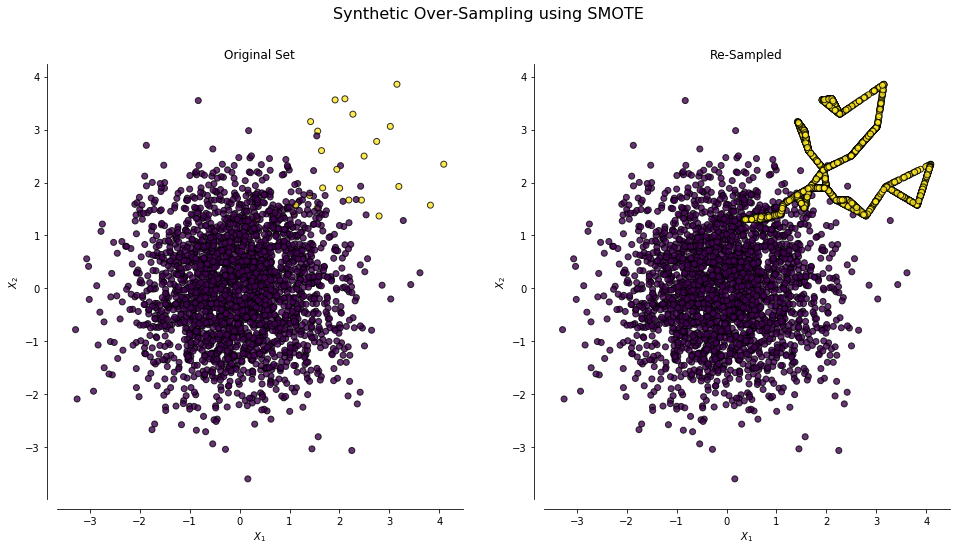

In [18]:
from imblearn.over_sampling import SMOTE

# K = 5, sampling strategy = 1 means that balanced sample is generated. In 
smote_k2 = SMOTE(k_neighbors=2 ,sampling_strategy= 1,random_state= 0)

# Use smote to resample
X_train_smote, y_train_smote = smote_k2.fit_resample(X_train,y_train)

plot_resample(X_train,y_train, X_train_smote,y_train_smote, title='Synthetic Over-Sampling using SMOTE')

Using SMOTE with 2 nearest neighbors, one can clearly see that new instances are introduced linearly between the k-nearest neighbors. Note, that in order to achieve a balanced dataset, SMOTE repeats the loop once every point has been visited. Using the 5-nearest neighbors as proposed by Chawla et al. (2002), the resulting sample is the following.

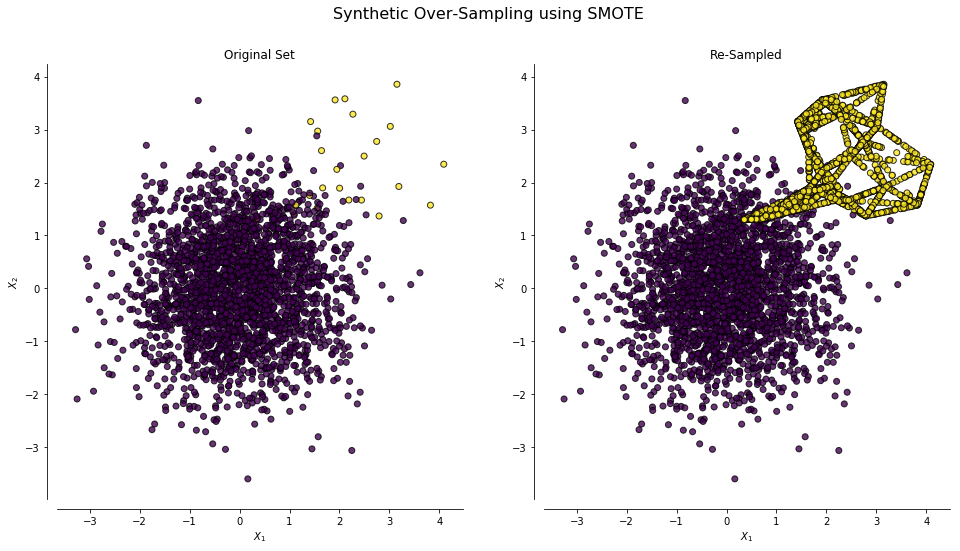

In [19]:
# K = 5, sampling strategy = 1 means that balanced sample is generated. In 
smote = SMOTE(k_neighbors=5 ,sampling_strategy= 1,random_state= 0)

# Use smote to resample
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

plot_resample(X_train,y_train, X_train_smote,y_train_smote, title='Synthetic Over-Sampling using SMOTE')

Using the 5-nearest neighbors, the distribution of the features has a less "linear" shape than using the 2-nearest neigbors. I will now fit the logistic regression model on the "smoted" data using the 5-nearest neighbors and a balanced sample.

,Accuracy,Precision,Recall
0,0.9924,0.636364,0.56


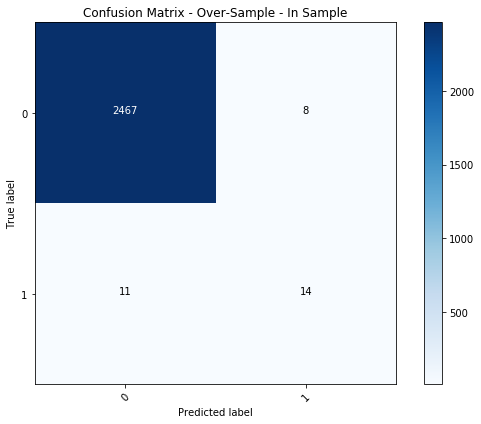

In [20]:
# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
smote_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model 
smote_model.fit(X_train_smote, y_train_smote);

# Correct the intercept 
correct_intercept_logit(smote_model, y_train, y_train_smote)

# Make predictions on testing values
smote_pred = smote_model.predict(X_test)

# Get confusion matrix using sklearn metrics (now in-sample)
cnf_matrix = metrics.confusion_matrix(y_test,smote_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Over-Sample - In Sample', classes= ['0','1'],figsize=(8,6))

# Get scores 
score_model(y_test,smote_pred)

Compared to the baseline model, recall improved only slightly, while as usual, precision dropped. Interestingly, there is no major difference between the performance when using SMOTE or random-oversampling. However, this could be due to this particular example. 

The changes in the decision boundary are hard to gauge visually, as indicated below. 

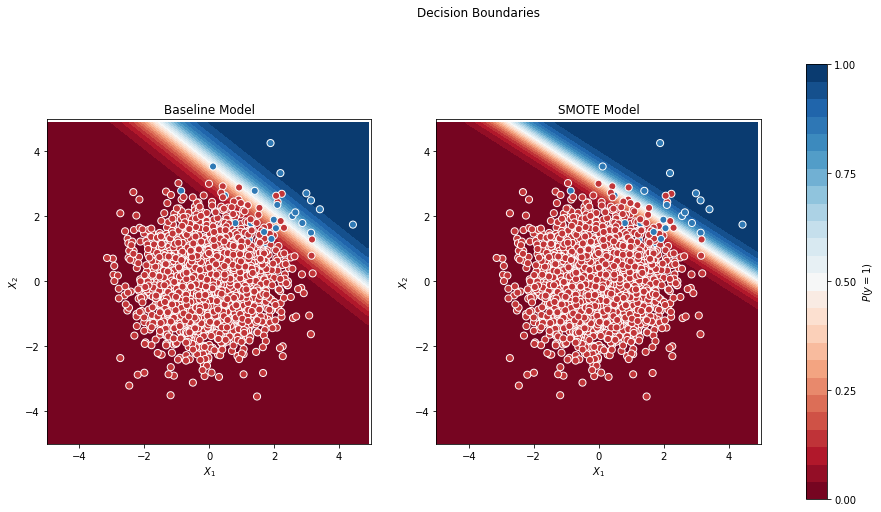

In [21]:
plot_decision_resample([baseline_model,smote_model],X_test, y_test,titles=['Baseline Model', 'SMOTE Model'])

##### SMOTE with random undersampling

Sincce the authors of SMOTE mentioned that the performance of SMOTE is best when combined with under-sampling, I will also test this hybrid method. As before, I am using SMOTE with 5-nearest neighbors. Since `imblearn`s `RandomUnderSampler` can't undersample the majority class below an equally balanced sample, I am using a custom undersampling function which takes the "smoted" dataset and removes instances of the majority class randomly.

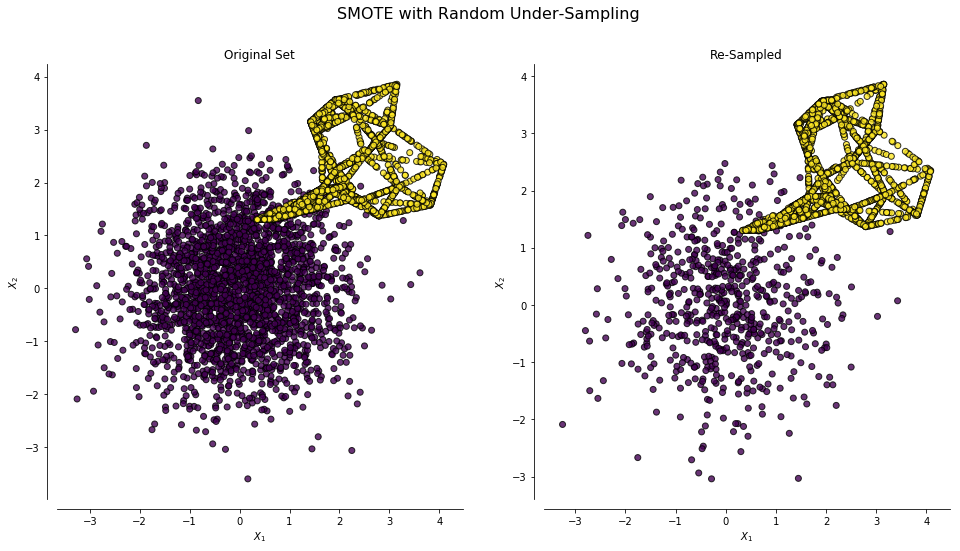

In [22]:
# SMOTE sampler
smote = SMOTE(k_neighbors=5 ,sampling_strategy= 1)

# Use smote and remove 0 class instances 
X_train_smote_undersampled,y_train_smote_undersampled = smote_undersampler(smote,X_train = X_train,
                                                                           y_train = y_train,
                                                                           strategy= 0.2)
plot_resample(X_train_smote,y_train_smote,X_train_smote_undersampled, y_train_smote_undersampled, 
              title= 'SMOTE with Random Under-Sampling')

,Accuracy,Precision,Recall
0,0.992,0.619048,0.52


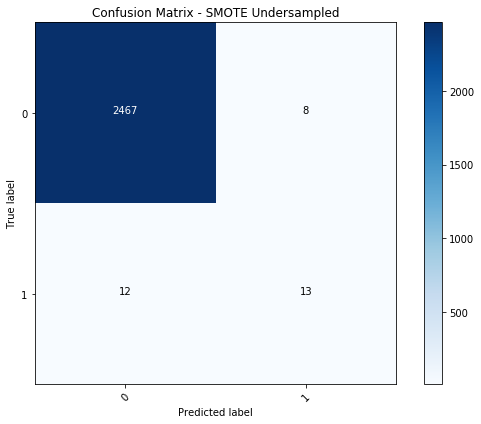

In [23]:
#Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
smote_under_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model 
smote_under_model.fit(X_train_smote_undersampled, y_train_smote_undersampled);

# Correct the intercept 
correct_intercept_logit(smote_under_model, y_train, y_train_smote_undersampled)

# Make predictions on testing values
smote_pred_under = smote_under_model.predict(X_test)

# Get confusion matrix using sklearn metrics (now in-sample)
cnf_matrix = metrics.confusion_matrix(y_test,smote_pred_under)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - SMOTE Undersampled', classes= ['0','1'],figsize=(8,6))

# Get scores 
score_model(y_test,smote_pred_under)

The resulting classifier has a higher recall than SMOTE or random over-sampling. Precision has dropped more than in the SMOTE-only case. Interestingly there is no improvement when compared to random under-sampling.

### 4. Simulations

Having discussed the ideas behind the sampling methods, I will now try to compare their performance when used with a logistic regression classifier. My goal is to identify which method performs best under which circumstances. I am primarily interested in performance dependend on base-rate and separation between clusters 

For every simulation, I am using `sklearns` `make_classification` function.  The function creates a dataset with gaussian features, given relative frequencies of each class, distnance between the two clusters and a given number of informative or non-informative features. I am only varying one variable of interest (e.g. base-rate) in each simulation. According to the documentation, the function creates clusters of standard normally distributed points on vertices of an n-dimensional hypercube where n is the number of informative features. The hypercubes have sides of length 2 times the class separation parameter. Further, the function introduces interdependence between the features and adds noise to the data. Unfortunately, the covariance matrix between the features can't be set and it's unclear how the covariances are generated. 

##### Performance dependent on base rates

The following output shows the performance of each sampling-method and the basline classifier without sampling at different base rates. For every base rate I am simulating 500 classification problems and storing the performance of each method. I then take the average of each metric over these 500 runs. Every classification problem consists of 2000 observations with 20 features, 10 of them informative. The class separation is 0.6. Like before, the sample will be split in half into stratified training and testing sets.  The sampling method is used on the training set and each model is tested on the original testing set. Except for SMOTE with under-sampling, all methods generate equally balanced samples. SMOTE with under-sampling creates a sample in where the previous minority class actually makes up 90 percent of the new sample.

In [28]:
# Instantiate the model, always the same model it's just going to be refit every time
model =  LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Instantiate all samplers, smote_undersampler is a function of smote
undersampler = RandomUnderSampler(sampling_strategy=1)
oversampler = RandomOverSampler(sampling_strategy=1)
smote = SMOTE(k_neighbors=5,sampling_strategy=1)

if simulate:
    
    # takes about 45 mins 

    # Ignore warnings, these would occur from precision 0
    import warnings
    warnings.filterwarnings("ignore")

    # Strategy names for result df columns
    strat_names =  ['Baseline', 'Undersampling', 'Oversampling','SMOTE', 'SMOTE Undersampling']

    # Number of total samples in each simulation
    n = 2000

    # Number of simulations per sample
    n_simulations = 500

    # Lists to store results for every base rate level, will be turned into result data-frames
    avg_accuracy = []
    avg_precision = []
    avg_recall = []
    avg_auc = []

    # Different base rates
    rates = np.linspace(0.01,0.4,40)

    # Simulate n_simulations at every base rate and take average metrics
    for base_rate in rates:
    
        # Get current weights of the classes, first class is the majority class, second the one of interest.
        weights = [1-base_rate,base_rate]
    
        # Temporary lists to store results in
        accuracy_list = []
        precision_list = []
        recall_list = []
        auc_list = []
    
        # Simulate at current base rate
        for i in range(0,n_simulations):
        

            # Make a new dataset
            x,y = make_classification(n_samples=n, n_features=20,
                                   n_informative=10, n_redundant=0, n_repeated=0,
                                   n_classes=2,
                                   n_clusters_per_class=1,
                                   weights=weights,
                                   class_sep=0.6, flip_y = 0)
    
            # Train-test-split, stratified
            X_train , X_test, y_train, y_test = train_test_split(x,y, test_size = 0.5, stratify = y)
        
            # Sample Fit metrics for all different strategies
        
            # Baseline
            acc_base, prec_base, rec_base, auc_base = sample_fit_metrics(model,X_train , 
                                                                X_test, y_train, y_test,sampler= None)
    
            # Undersampling
            acc_under, prec_under, rec_under, auc_under= sample_fit_metrics(model,X_train, X_test, y_train, y_test, 
                                                                                   sampler = undersampler)
            # Oversampling  
            acc_over, prec_over, rec_over, auc_over= sample_fit_metrics(model,X_train , X_test, 
                                                                y_train, y_test, sampler = oversampler)
    
            # SMOTE
            acc_smote, prec_smote, rec_smote, auc_smote =sample_fit_metrics(model,X_train , X_test, 
                                                                y_train, y_test, sampler = smote)
            # SMOTE with undersampling
            acc_smote_u, prec_smote_u, rec_smote_u, auc_smote_u= sample_fit_metrics(model,X_train, X_test, 
                                                                                    y_train, y_test, 
                                                                                    sampler = smote_undersampler, 
                                                                                    undersampler_strategy = 0.1)
                                                                                    
            # Store values in lists
            accuracy_list.append([acc_base,acc_under,acc_over,acc_smote,acc_smote_u])
            precision_list.append([prec_base,prec_under,prec_over,prec_smote,prec_smote_u])
            recall_list.append([rec_base,rec_under,rec_over,rec_smote,rec_smote_u])
            auc_list.append([auc_base,auc_under,auc_over,auc_smote,auc_smote_u])
    
        # Store averages in lists 
        avg_accuracy.append(pd.DataFrame.from_records(accuracy_list,columns=strat_names).mean().values)
        avg_precision.append(pd.DataFrame.from_records(precision_list,columns=strat_names).mean().values)
        avg_recall.append(pd.DataFrame.from_records(recall_list,columns=strat_names).mean().values)
        avg_auc.append(pd.DataFrame.from_records(auc_list,columns=strat_names).mean().values)

    # Make summary data frames for all rates
    accuracy_pd = pd.DataFrame.from_records(avg_accuracy,columns= strat_names, index = rates)
    precision_pd = pd.DataFrame.from_records(avg_precision, columns=strat_names, index = rates)
    recall_pd = pd.DataFrame.from_records(avg_recall, columns=strat_names, index = rates)
    auc_pd = pd.DataFrame.from_records(avg_auc, columns=strat_names, index = rates)
    
    if save:
        accuracy_pd.to_csv(filepath+'Accuracy_Base_Rates.csv')
        precision_pd.to_csv(filepath+'Precision_Base_Rates.csv')
        recall_pd.to_csv(filepath+'Recall_Base_Rates.csv')
        auc_pd.to_csv(filepath+'AUC_Base_Rates.csv')
    
else:
    accuracy_pd = pd.read_csv(filepath+'Accuracy_Base_Rates.csv', index_col= 0)
    precision_pd = pd.read_csv(filepath+'Precision_Base_Rates.csv',index_col = 0)
    recall_pd = pd.read_csv(filepath+'Recall_Base_Rates.csv', index_col = 0 )
    auc_pd = pd.read_csv(filepath+'AUC_Base_Rates.csv', index_col = 0)

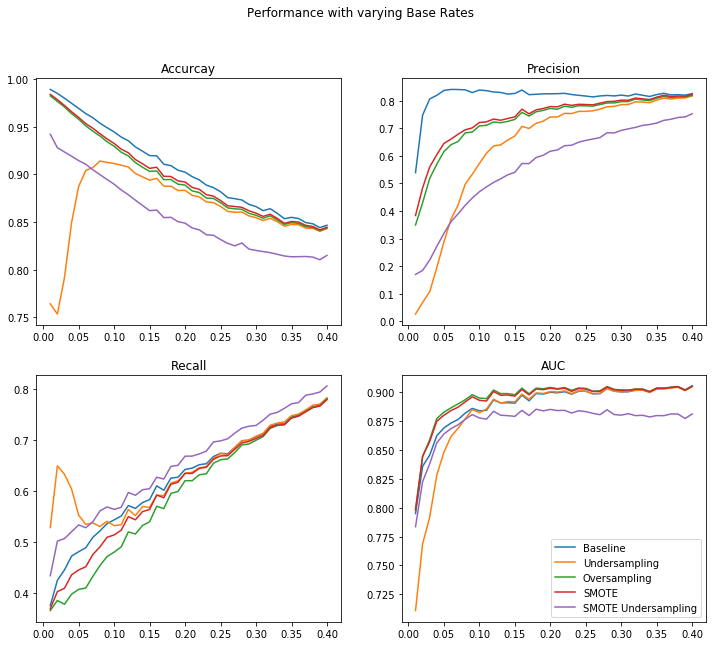

In [29]:
# Plot setting
plt.rcParams['figure.figsize'] = (10,8)

# Plot results
plot_results(accuracy_pd,precision_pd,recall_pd,auc_pd, title = 'Performance with varying Base Rates')

Naturally, at every base-rate, the accuracy of the baseline classifier is the highest. However, given the class-imbalance issue, this metric alone is not informative.  

When comparing the precision across the various methods, the baseline model performs best. This is not surprising either, since the baseline model is expected to have few cases of false positives, given that it rarley predicts positive cases.
Random under-sampling and SMOTE with under-sampling have the lowest precision across all methods. For highly imbalanced samples, the precision of under-sampling and SMOTE with under-sampling is almost zero. This hints towards a reversal of the bias of the classifier, even when correcting the intercept. This can also be seen in the low accuracy of under-sampling and SMOTE with under-sampling. Both methods have high false positive rates, resulting in low accuracy in imbalanced samples. Across methods, precision improves with rising base rate. 

When comparing recall, random under-sampling shows the best performance, at very low base-rates (<0.05) followed by SMOTE with undersampling. There's a spike of recall for under-sampling at a base rate of approx. 2-3 percent. This spike, together with the low precision, could indicate a reversal of bias in the under-sampling model. With a sample of 1000 obseravtions, to achieve balance, under-sampling discards 980 observations of the majority class at a base rate of 1 percent. As discussed before, this could leat to the potential loss of important information. SMOTE alone and random-oversampling do not improve out-of sample recall on average. This could be indicative of the in-sample overfitting issue when using over-sampling methods. 

Comparing precision and recall, the trade-off between the two becomes apparent. Under-sampling and SMOTE with under-sampling have the best recall in imbalanced samples, but also the lowest precision. Overall, SMOTE with under-sampling seems to achieve the best trade-off. This could be due to the fact that when using SMOTE with under-sampling, not as many majority class instances are removed when compared to simple under-sampling. The "smoted" data-set is already balanced, so under-sampling doesn't remove almost all majority class instances at low base-rates. 

##### Performance dependent on class separation

As shown by the simple examples in $R^2$, the classification task becomes much harder when both classes are closer to each other. I will now try to identify which method performs well at which separation. The `make_classification` function has a parameter `class_sep` which can be used to set the separation between clusters. The base rate over all simulations is set to five percent, the number of features is 20 and the number of informative features is 10.

In [26]:
if simulate:
    
    # Takes about 30min hour
   
    # Base rates
    base_rate = 0.05

    # Get current weights of the classes, first class is the majority class, second the one of interest.
    weights = [1-base_rate,base_rate]

    # Lists to store results for every base rate level, will be turned into result data-frames
    avg_accuracy = []
    avg_precision = []
    avg_recall = []
    avg_auc = []

    # Levels of seperation
    separations = np.linspace(0.1,1,10)

    # Number of simulations per sample
    n_simulations = 500

    # Simulate n_simulations at every base rate and take average metrics
    for sep in separations:
        # Temporary lists to store results in
        accuracy_list = []
        precision_list = []
        recall_list = []
        auc_list = []
    
        # Simulate at current base rate
        for i in range(0,n_simulations):
        
            # Make a new dataset
            x,y = make_classification(n_samples=n, n_features=20,
                                   n_informative=10, n_redundant=0, n_repeated=0,
                                   n_classes=2,
                                   n_clusters_per_class=1,
                                   weights=list(weights),
                                   class_sep=sep, flip_y = 0)
    
            # Train-test-split, stratified
            X_train , X_test, y_train, y_test = train_test_split(x,y, test_size = 0.5, stratify = y)
        
            # Sample Fit metrics for all different strategies
        
            # Baseline
            acc_base, prec_base, rec_base, auc_base = sample_fit_metrics(model,X_train , 
                                                                X_test, y_train, y_test,sampler= None)
    
            # Undersampling
            acc_under, prec_under, rec_under, auc_under= sample_fit_metrics(model,X_train, X_test, y_train, y_test, 
                                                                                   sampler = undersampler)
            # Oversampling  
            acc_over, prec_over, rec_over, auc_over= sample_fit_metrics(model,X_train , X_test, 
                                                                    y_train, y_test, sampler = oversampler)
    
            # SMOTE
            acc_smote, prec_smote, rec_smote, auc_smote =sample_fit_metrics(model,X_train , X_test, 
                                                                y_train, y_test, sampler = smote)
            # SMOTE with undersampling
            acc_smote_u, prec_smote_u, rec_smote_u, auc_smote_u= sample_fit_metrics(model,X_train, X_test, 
                                                                                    y_train, y_test, 
                                                                                    sampler = smote_undersampler, 
                                                                                    undersampler_strategy = 0.1)
        
            # Store values in lists
            accuracy_list.append([acc_base,acc_under,acc_over,acc_smote,acc_smote_u])
            precision_list.append([prec_base,prec_under,prec_over,prec_smote,prec_smote_u])
            recall_list.append([rec_base,rec_under,rec_over,rec_smote,rec_smote_u])
            auc_list.append([auc_base,auc_under,auc_over,auc_smote,auc_smote_u])
    
        # Store averages in lists 
        avg_accuracy.append(pd.DataFrame.from_records(accuracy_list,columns=strat_names).mean().values)
        avg_precision.append(pd.DataFrame.from_records(precision_list,columns=strat_names).mean().values)
        avg_recall.append(pd.DataFrame.from_records(recall_list,columns=strat_names).mean().values)
        avg_auc.append(pd.DataFrame.from_records(auc_list,columns=strat_names).mean().values)

    # Make summary data frames for all rates
    accuracy_pd_sep = pd.DataFrame.from_records(avg_accuracy,columns= strat_names, index = separations)
    precision_pd_sep = pd.DataFrame.from_records(avg_precision, columns=strat_names, index = separations)
    recall_pd_sep = pd.DataFrame.from_records(avg_recall, columns=strat_names, index = separations)
    auc_pd_sep = pd.DataFrame.from_records(avg_auc, columns=strat_names, index = separations)
    
    if save:
        accuracy_pd_sep.to_csv(filepath+'accuracy_pd_sep.csv')
        precision_pd_sep.to_csv(filepath+'precision_pd_sep.csv')
        recall_pd_sep.to_csv(filepath+'recall_pd_sep.csv')
        auc_pd_sep.to_csv(filepath+'auc_pd_sep.csv')
        
else:
    accuracy_pd_sep = pd.read_csv(filepath+'accuracy_pd_sep.csv', index_col= 0)
    precision_pd_sep = pd.read_csv(filepath+'precision_pd_sep.csv', index_col=0)
    recall_pd_sep = pd.read_csv(filepath+'recall_pd_sep.csv', index_col=0)
    auc_pd_sep = pd.read_csv(filepath+'auc_pd_sep.csv',index_col=0)

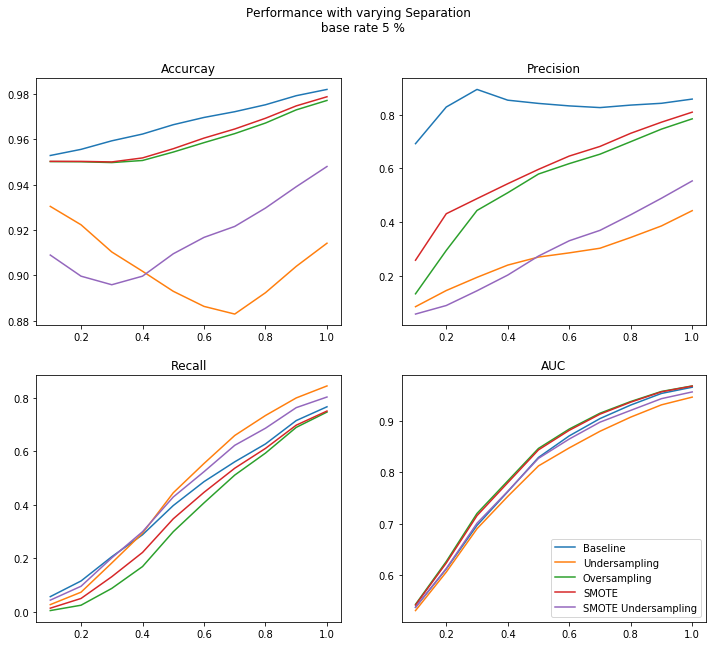

In [32]:
# Plot results
plot_results(accuracy_pd_sep,precision_pd_sep,recall_pd_sep,auc_pd_sep, title = 'Performance with varying Separation \n base rate 5 %')

As expected, all methods perform very poorly in terms of recall at separations below 0.4.

As seen with varying base rates, the precision of under-sampling and SMOTE with under-sampling are the lowest throughout the simulations. It seems like SMOTE with under-sampling starts to outperform random under-sampling once the separation between clusters has reached 0.5. As expected, the baseline model has the highest precision. 

In terms of recall, all methods perform bad for separations below 0.4, but this would be generally an impossible classification problem, independently of the base rate. Overall, under-sampling and SMOTE with under-sampling improve recall the most. Both methods do not differ much in terms of recall. SMOTE alone and random over-sampling do not improve out of sample recall when compared to the baseline model. 

Again, the precision-recall trade-off is apparent. Given that under-sampling and SMOTE with under-sampling do not differ significantly in terms of recall, but in terms of precision, SMOTE with under-sampling can be seen as the preferred method (Not taking separations below 0.4 into account).

### 5. Discussion

When dealing with class imbalance issues, sampling techniques can help to improve recall, but often at the expense of precision. Random-oversampling and SMOTE do not seem to improve out-of sample recall, especially for highly imbalanced datasets. Random-undersampling when used on highly imbalanced data-sets can improve recall, but at a serious reduction of precision. SMOTE with under-sampling seems to somehow achieve a good trade-off, since not as many majority class instances are discareded. In my simulations, logistic regression seems to work quite well, once the base-rate exceeds 20 percent. Ultimately, the cost-matrix should guide the decision, since different problems are associated with differnt misclassification costs. When false-negatives are costly, sampling methods such as under-sampling and SMOTE with under-sampling can help. 

In the end, the performance of each sampling method depends on the choice of hyperparameters, such as the percentage of under- or over-sampling. In order to get a more comprehensive view of when to use which sampling strategy, further simulations are needed, in which these parameters are varied. Another necessary extension is the use of pre-defined dependencies between features, as the `make_classification` function doesn't allow for pre-specified covariance matrices.

In the end, when dealing with class imbalance issues, sampling techniques are only one tool out of many. As seen before, changing the decision boundary in logistic classifiers can improve recall in imbalanced samples, at only a slight reduction of precision. Additionally, one should try different classifiers, such as decision trees or support vector machines and compare the performance to logistic regression. 

#### References

Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. Journal of artificial intelligence research, 16, 321-357.

Ha, T. M., & Bunke, H. (1997). Off-line, handwritten numeral recognition by perturbation method. IEEE Transactions on Pattern Analysis & Machine Intelligence, (5), 535-539.

Hoens, T. R., Chawla, N. V (2013). Imbalanced Datasets: From Sampling to Classifiers in " Imbalanced learning: foundations, algorithms, and applications." edited by He, H., & Ma, Y. John Wiley & Sons

King, G., & Zeng, L. (2001). Logistic regression in rare events data. Political analysis, 9(2), 137-163.

Kuhn, M., & Johnson, K. (2013). Applied predictive modeling (Vol. 26). New York: Springer.

National Cancer Institute statistics: https://seer.cancer.gov/statfacts/html/prost.html